# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [5]:
# Verificando valores únicos nas colunas 'ca' e 'thal'
valores_unicos_ca = df['ca'].unique()
valores_unicos_thal = df['thal'].unique()

valores_unicos_ca, valores_unicos_thal

(array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object),
 array(['6.0', '3.0', '7.0', '?'], dtype=object))

In [7]:
# Calculando a frequência dos valores '?' nas colunas 'ca' e 'thal'
frequencia_ca = df['ca'].value_counts()['?']
frequencia_thal = df['thal'].value_counts()['?']

frequencia_ca, frequencia_thal

(4, 2)

In [9]:
# Substituindo '?' pela moda nas colunas 'ca' e 'thal'
moda_ca = df['ca'].mode()[0]
moda_thal = df['thal'].mode()[0]

df['ca'].replace('?', moda_ca, inplace=True)
df['thal'].replace('?', moda_thal, inplace=True)

# Convertendo 'ca' e 'thal' para tipos numéricos
df['ca'] = pd.to_numeric(df['ca'])
df['thal'] = pd.to_numeric(df['thal'])

# Verificando novamente os tipos de dados para confirmar as mudanças
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    float64
 12  thal         303 non-null    float64
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 35.6 KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [12]:
def bivariada(dataframe, var_resposta, var_explicativa):
    # Agrupando os dados com base na variável explicativa e na variável resposta
    bivariada_df = dataframe.groupby([var_explicativa, var_resposta]).size().unstack(fill_value=0)
    bivariada_df.columns = ['saudaveis', 'doentes']
    
    # Calculando o total, a média de doentes, odds e logito
    bivariada_df['total'] = bivariada_df['saudaveis'] + bivariada_df['doentes']
    bivariada_df['media_doentes'] = bivariada_df['doentes'] / bivariada_df['total']
    bivariada_df['odds'] = bivariada_df['doentes'] / bivariada_df['saudaveis']
    bivariada_df['logito'] = np.log(bivariada_df['odds'].replace(0, np.nan))
    
    # Selecionando a categoria com maior total como referência para Odds Ratio e WOE
    ref_categoria = bivariada_df['total'].idxmax()
    bivariada_df['odds_ratio'] = bivariada_df['odds'] / bivariada_df.loc[ref_categoria, 'odds']
    bivariada_df['woe'] = np.log(bivariada_df['odds_ratio'].replace(0, np.nan))
    
    # Reordenando as colunas para melhor visualização
    bivariada_df = bivariada_df[['saudaveis', 'doentes', 'total', 'media_doentes', 'odds', 'odds_ratio', 'logito', 'woe']]
    
    return bivariada_df

In [14]:
# Aplicando a função bivariada para as variáveis 'cp', 'restecg', e 'slope'
bivariada_cp = bivariada(df, 'flag_doente', 'cp')
bivariada_restecg = bivariada(df, 'flag_doente', 'restecg')
bivariada_slope = bivariada(df, 'flag_doente', 'slope')

In [15]:
bivariada_cp

,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,woe
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.162500,-0.826679,-1.817077
2.0,41,9,50,0.180000,0.219512,0.081533,-1.516347,-2.506746
3.0,68,18,86,0.209302,0.264706,0.098319,-1.329136,-2.319535
4.0,39,105,144,0.729167,2.692308,1.000000,0.990399,0.000000


In [16]:
bivariada_restecg

,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,woe
restecg,,,,,,,,
0.0,95,56,151,0.370861,0.589474,1.000000,-0.528525,0.000000
1.0,1,3,4,0.750000,3.000000,5.089286,1.098612,1.627137
2.0,68,80,148,0.540541,1.176471,1.995798,0.162519,0.691044


In [17]:
bivariada_slope

,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,woe
slope,,,,,,,,
1.0,106,36,142,0.253521,0.339623,1.000000,-1.079920,0.000000
2.0,49,91,140,0.650000,1.857143,5.468254,0.619039,1.698959
3.0,9,12,21,0.571429,1.333333,3.925926,0.287682,1.367602


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [18]:
def bivariada_quantitativa(dataframe, var_resposta, var_explicativa, num_categorias=5):
    # Dividindo a variável explicativa em categorias baseadas em quantis
    dataframe['categoria'] = pd.qcut(dataframe[var_explicativa], q=num_categorias, duplicates='drop')
    
    # Agrupando os dados com base na nova categoria criada e na variável resposta
    bivariada_df = dataframe.groupby(['categoria', var_resposta]).size().unstack(fill_value=0)
    bivariada_df.columns = ['saudaveis', 'doentes']
    
    # Calculando o total, a média de doentes, odds e logito
    bivariada_df['total'] = bivariada_df['saudaveis'] + bivariada_df['doentes']
    bivariada_df['media_doentes'] = bivariada_df['doentes'] / bivariada_df['total']
    bivariada_df['odds'] = bivariada_df['doentes'] / bivariada_df['saudaveis']
    bivariada_df['logito'] = np.log(bivariada_df['odds'].replace(0, np.nan))
    
    # Selecionando a categoria com maior total como referência para Odds Ratio e WOE
    ref_categoria = bivariada_df['total'].idxmax()
    bivariada_df['odds_ratio'] = bivariada_df['odds'] / bivariada_df.loc[ref_categoria, 'odds']
    bivariada_df['woe'] = np.log(bivariada_df['odds_ratio'].replace(0, np.nan))
    
    # Reordenando as colunas para melhor visualização
    bivariada_df = bivariada_df[['saudaveis', 'doentes', 'total', 'media_doentes', 'odds', 'odds_ratio', 'logito', 'woe']]
    
    # Removendo a coluna categoria adicionada para análise
    dataframe.drop('categoria', axis=1, inplace=True)
    
    return bivariada_df

In [27]:
# Testando a função com a variável 'age'
bivariada_quantitativa_df = bivariada_quantitativa(df, 'flag_doente', 'age')
bivariada_quantitativa_df

C:\Users\Matheus Cerqueira\AppData\Local\Temp\ipykernel_21360\3123464563.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bivariada_df = dataframe.groupby(['categoria', var_resposta]).size().unstack(fill_value=0)


,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,woe
categoria,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.279324,-1.077559,-1.275385
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.429792,-0.646627,-0.844453
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.000000,0.197826,0.000000
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.019724,0.900787,0.702961
"(62.0, 77.0]",30,30,60,0.500000,1.000000,0.820513,0.000000,-0.197826


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [34]:
# Convertendo todas as colunas numéricas para float64
X = X.astype(float)

try:
    modelo = sm.Logit(y, X)
    resultado = modelo.fit()
    print(resultado.summary())
except Exception as e:
    print("Erro ao ajustar o modelo:", str(e))

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Jul 2024   Pseudo R-squ.:                  0.3097
Time:                        20:29:16   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.3407      1.621     -5.145      0.000     -11.518      -5.163
sex_1.0        1.8094      0.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [35]:
# Calculando as probabilidades preditas do modelo
probabilidades_preditas = resultado.predict(X)

probabilidades_preditas.head()

0    0.458229
1    0.944123
2    0.886566
3    0.134929
4    0.027278
dtype: float64

In [39]:
# Categorizando as probabilidades preditas em 5 grupos iguais
categorias_probabilidades = pd.qcut(probabilidades_preditas, 5, labels=False, duplicates='drop')

# Adicionando as categorias ao dataframe original
df['categoria_probabilidade'] = categorias_probabilidades

# Visualizando a distribuição das categorias
df['categoria_probabilidade'].value_counts().sort_index()

categoria_probabilidade
0    62
1    59
2    62
3    59
4    61
Name: count, dtype: int64

In [40]:
# Calculando a probabilidade média predita por grupo
media_prob_predita_por_grupo = df.groupby('categoria_probabilidade')['flag_doente'].mean()

media_prob_predita_por_grupo

categoria_probabilidade
0    0.080645
1    0.152542
2    0.483871
3    0.762712
4    0.819672
Name: flag_doente, dtype: float64

In [44]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,categoria_probabilidade
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,2
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,4
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,4
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1,0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1,4
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1,4
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1,1,0


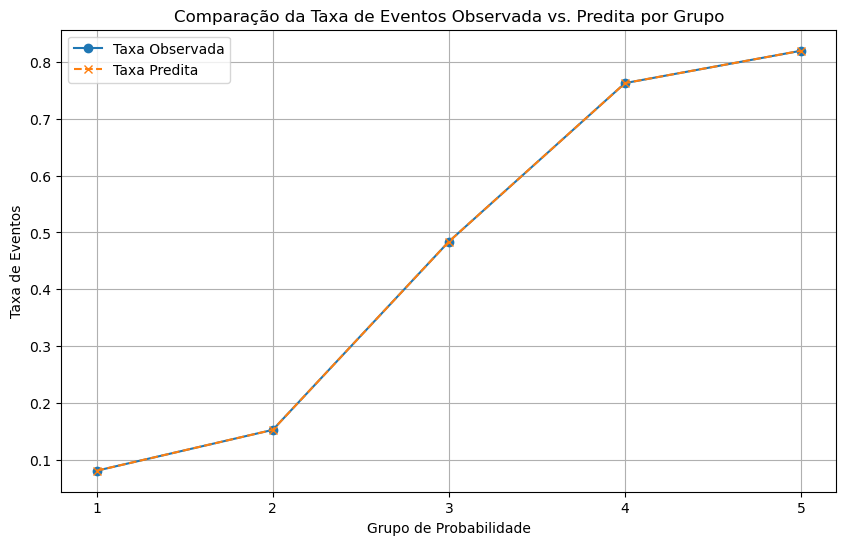

In [43]:
grupos = range(1, 6)  # Grupos de 1 a 5
taxa_observada = media_prob_predita_por_grupo.values

plt.figure(figsize=(10, 6))
plt.plot(grupos, taxa_observada, label='Taxa Observada', marker='o')
plt.plot(grupos, taxa_observada, label='Taxa Predita', linestyle='--', marker='x')
plt.title('Comparação da Taxa de Eventos Observada vs. Predita por Grupo')
plt.xlabel('Grupo de Probabilidade')
plt.ylabel('Taxa de Eventos')
plt.xticks(grupos)
plt.legend()
plt.grid(True)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [48]:
# Calculando predições binárias com limiar de 0.5
predicoes_binarias = (probabilidades_preditas >= 0.5).astype(int)

acuracia = accuracy_score(y, predicoes_binarias)
acuracia

0.7953795379537953

In [50]:
# Calculando a área sob a curva ROC (AUC)
auc = roc_auc_score(y, probabilidades_preditas)

# Calculando o GINI
gini = 2 * auc - 1
auc, gini

(0.8519477101245833, 0.7038954202491665)

In [52]:
# Predições de eventos positivos e negativos
positivos = probabilidades_preditas[y == 1]
negativos = probabilidades_preditas[y == 0]

# Calculando a estatística KS
ks_statistic, ks_pvalue = ks_2samp(positivos, negativos)
ks_statistic, ks_pvalue

(0.5929549043691876, 3.890148919718764e-25)

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [65]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'flag_doente',
       'categoria_probabilidade', 'sex_numeric', 'age_sex_interaction'],
      dtype='object')

In [66]:
# Convertendo todas as colunas de X_new para float64
X_new = X_new.astype(float)

# Tentando ajustar o modelo novamente
try:
    modelo_novo = sm.Logit(y, X_new)
    resultado_novo = modelo_novo.fit()
    print(resultado_novo.summary())
except Exception as e:
    print("Erro ao ajustar o modelo:", str(e))

Optimization terminated successfully.
         Current function value: 0.430571
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Tue, 02 Jul 2024   Pseudo R-squ.:                  0.3757
Time:                        20:53:59   Log-Likelihood:                -130.46
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 6.596e-30
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.3495      2.909     -1.495      0.135     -10.051       1.352
se

In [68]:
probabilidades_preditas_novo = resultado_novo.predict(X_new)

In [71]:
# Calculando a acurácia novamente com o modelo melhorado
acuracia_novo = accuracy_score(y, (probabilidades_preditas_novo >= 0.5).astype(int))

# AUC e GINI
auc_novo = roc_auc_score(y, probabilidades_preditas_novo)
gini_novo = 2 * auc_novo - 1

# KS
positivos_novo = probabilidades_preditas_novo[y == 1]
negativos_novo = probabilidades_preditas_novo[y == 0]
ks_statistic_novo, ks_pvalue_novo = ks_2samp(positivos_novo, negativos_novo)

acuracia_novo, auc_novo, gini_novo, ks_statistic_novo, ks_pvalue_novo

(0.8052805280528053,
 0.8823477803123355,
 0.764695560624671,
 0.6123442709247237,
 6.590546774661342e-27)